In [1]:
import tifffile
import json
from pyproj import Transformer

In [2]:
def read_tiff_metadata(tiff_file):
    with tifffile.TiffFile(tiff_file) as tif:
        metadata = tif.geotiff_metadata["ModelTransformation"]
        w = tif.pages[0].tags["ImageWidth"].value
        h = tif.pages[0].tags["ImageLength"].value
        # metadata[0][0] - raster cell dim, metadata[0][3] - easting coord, metadata[1][3] - northing
        # return block w, h and coords of upper left
        return [metadata[0][0] * w, metadata[0][0] * h, metadata[0][3], metadata[1][3]]


In [3]:
read_tiff_metadata("../data/DOF5-20240420-E0607.tif")

[2250.0, 3000.0, 468500.0, 115000.0]

Primer	    Opis
0.50	← velikost celice rastra po e-osi (v metrih)
0.00	← zasuk okoli e-osi (praviloma ga ni oziroma je 0)
0.00	← zasuk okoli n-osi (praviloma ga ni oziroma je 0)
-0.50	← negativna velikost celice rastra po e-osi (v metrih)
500000.25	← e-koordinata sredine leve zgornje celice rastra (angl. easting coordinate)
119999.75	← n-koordinata sredine leve zgornje celice rastra (angl. northing coordinate)


In [4]:
def tiff_metadata_to_geojson(tiff_metadata):
    # Extract metadata
    cell_size_e, neg_cell_size_e, easting, northing = tiff_metadata

    # # Define projection systems
    # input_proj = Proj(init='epsg:3912')  # D96/TM
    # output_proj = Proj(init='epsg:4326')  # WGS 84

    transformer = Transformer.from_crs("EPSG:3912", "EPSG:4326")

    # Transform coordinates
    ul_lat, ul_lon = transformer.transform(easting, northing)

    # Calculate other corner coordinates
    lr_lat, lr_lon = transformer.transform(easting + cell_size_e, northing - neg_cell_size_e)

    # Create GeoJSON structure
    geojson_feature = {
        "type": "Feature",
        "geometry": {
            "type": "Polygon",
            "coordinates": [
                [
                    [ul_lon, ul_lat],
                    [lr_lon, ul_lat],
                    [lr_lon, lr_lat],
                    [ul_lon, lr_lat],
                    [ul_lon, ul_lat]
                ]
            ]
        },
        "properties": {}
    }

    geojson_data = {
        "type": "FeatureCollection",
        "features": [
            geojson_feature
        ]
    }

    return geojson_data

# Convert to GeoJSON
geojson_result = tiff_metadata_to_geojson(read_tiff_metadata("../data/DOF5-20240420-E0607.tif"))

# Output GeoJSON
with open("test.json", "w") as f:
    json.dump(geojson_result, f)

In [5]:
import torch
import torchvision
import matplotlib.pyplot as plt

In [39]:
def tiling_template(in_size, tile_size, img):
    assert len(img.shape) == 4, "Only pass batched imgs"
    b = imgs.shape[0]

    tile_count = []
    for in_dim, tile_dim in zip(in_size, tile_size):
        assert in_dim % tile_dim == 0, "Image size must be divisible by tile size"
        tile_count.append(in_dim // tile_dim)

    resizer = torchvision.transforms.Resize(size=in_size)
    unfolder = torch.nn.Unfold(kernel_size=tile_size, stride=tile_size)
    # tile height, tile width
    t_h, t_w = tile_size
    # vertical tile count, tile count horizontal
    t_c_h, t_c_w = tile_count

    img = resizer(img)

    # [b, C * t_h * t_w, total_tile_count]
    tiles = unfolder(img)
    # [b, C, t_h, t_w, total_tile_count] -> [b, total_tile_count, C, t_h, t_w] -> [b, t_dim_h, t_dim_w, C, t_h, t_w]
    tiles = tiles.view(b, -1, t_h, t_w, t_c_h * t_c_w).permute(0, 4, 1, 2, 3).view(b, t_c_h, t_c_w, -1, t_h, t_w)

    return tiles

In [40]:
img = torchvision.io.read_image("../data/test_img.png",
                                mode=torchvision.io.ImageReadMode.RGB).to(torch.float32)
imgs = torch.stack([img, img])
imgs.shape

torch.Size([2, 3, 1180, 888])

In [41]:
tiles = tiling_template((1024, 768), (256, 256), imgs)
tiles.shape

torch.Size([2, 4, 3, 3, 256, 256])

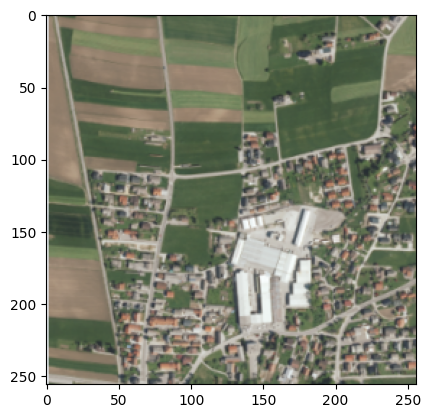

In [42]:
plt.imshow(tiles[0][0][0].permute(1, 2, 0).to(torch.uint8))

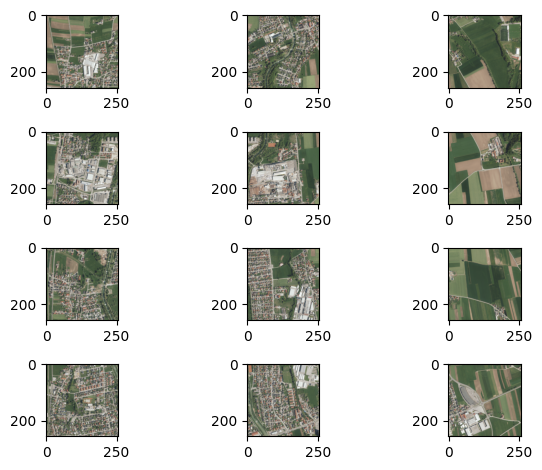

In [43]:
fig, axs = plt.subplots(4, 3)
for i in range(4):
    for j in range(3):
        axs[i][j].imshow(tiles[0][i][j].permute(1, 2, 0).to(torch.uint8))

plt.tight_layout()
plt.show()

In [18]:
folder = torch.nn.Fold(output_size=(1024, 768), kernel_size=(256, 256), stride=256)

# tiles.view(3, 256, 256, 12).permute(3, 0, 1, 2).view(4, 3, 3, 256, 256)
untiled = folder(tiles.view(12, 3, 256, 256).permute(1, 2, 3, 0).view(-1, 12))

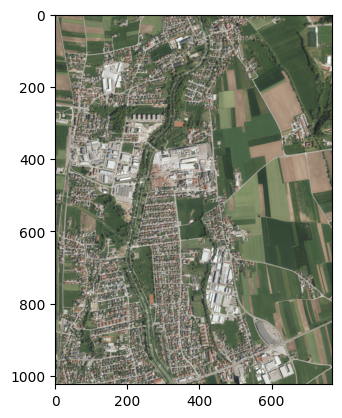

In [19]:
plt.imshow(untiled.permute(1, 2, 0).to(torch.uint8))